In [2]:
# import tensorflow as tf
import pandas as pd
import sklearn
from datetime import datetime, timedelta

weather_df = pd.read_csv('weather_data.csv')
observations_df = pd.read_csv('observations.csv')

# convert datetime to same format as observations_df
weather_df['Datetime'] = pd.to_datetime(weather_df['Datetime'], format='%Y%m%d%H')
weather_df['Date'] = weather_df['Datetime'].dt.date

# Use same format as weather_df
observations_df['Date'] = pd.to_datetime(observations_df[['year', 'month', 'day']])

# Group by id and Date to find all unique days per ID
day_indices = weather_df.groupby(['id', 'Date']).first().reset_index()

# make dict of observation ID with original date
observation_dates = {}
for _, row in observations_df.iterrows():
    observation_dates[row['id']] = row['Date']

# Calculate difference between observation date and weather date
def get_relative_day(row):
    obs_date = observation_dates.get(row['id'])
    this_date = pd.to_datetime(row['Date'])
    difference = (this_date - obs_date).days
    return difference

# Apply the function to get relative day
day_indices['RelativeDay'] = day_indices.apply(get_relative_day, axis=1)

# Add relative day to weather_df
day_map = day_indices.set_index(['id', 'Date'])['RelativeDay']
weather_df['RelativeDay'] = weather_df.set_index(['id', 'Date']).index.map(day_map)

# Variables to calculate aggregations for
weather_vars = ['Temperature', 'Humidity', 'Wind Speed', 'Dew/Frost Point', 
                'Wet Bulb Temperature', 'Specific Humidity']

# Time windows to aggregate over (days before and after the observation day)
time_windows = {
    'day_of': (0, 0),
    'day_before_after': (-1, 1),
    'three_days': (-3, 3),
    'one_week': (-7, 7),
    'two_weeks': (-14, 14)
}

# Function to calculate aggregates given ID and time window
def calculate_aggregates(weather_subset, var_name, window_name, start_day, end_day):
    # Filter data for given time window
    window_data = weather_subset[(weather_subset['RelativeDay'] >= start_day) & (weather_subset['RelativeDay'] <= end_day)]
    
    # Calculate aggregate and return as a series
    result = pd.Series({
        f"{var_name}_{window_name}_mean": window_data[var_name].mean(),
        f"{var_name}_{window_name}_min": window_data[var_name].min(),
        f"{var_name}_{window_name}_max": window_data[var_name].max(),
        f"{var_name}_{window_name}_median": window_data[var_name].median()
    })
    
    return result

# Create empty DataFrame to store results
all_features = []
result_rows = []

# For each observation row, calculate all aggregate weather data
for id_val in observations_df['id'].unique():
    id_weather = weather_df[weather_df['id'] == id_val]
        
    # Dictionary to store aggregated values for this ID
    id_features = {'id': id_val}
    
    # Iterate over all weather data variables
    for var in weather_vars:
        # iterate over all items in time_windows
        for window_name, (start_day, end_day) in time_windows.items():
            aggs = calculate_aggregates(id_weather, var, window_name, start_day, end_day)
            id_features.update(aggs)
            
            # Add feature names to our list (only once)
            if id_val == observations_df['id'].unique()[0]:
                all_features.extend(aggs.index.tolist())
    
    result_rows.append(id_features)

# Create DataFrame from results
aggregated_features = pd.DataFrame(result_rows)

# Merge with the original observations dataframe
observations_df = observations_df.merge(aggregated_features, on='id', how='left')

# Create list of feature names
weather_feature_names = all_features

print(f"Created {len(weather_feature_names)}  features")



# Add day of year as a feature to observations_df
observations_df['day_of_year'] = observations_df.apply(
    lambda row: datetime(row['year'], row['month'], row['day']).timetuple().tm_yday, 
    axis=1
)

# Drop rows with NaN values
observations_df = observations_df.dropna()

# Display the updated DataFrame
observations_df.head()





Created 120  features


,id,date_string,coordinates,PowderyMildew,longitude,latitude,year,month,day,Date,...,Specific Humidity_three_days_median,Specific Humidity_one_week_mean,Specific Humidity_one_week_min,Specific Humidity_one_week_max,Specific Humidity_one_week_median,Specific Humidity_two_weeks_mean,Specific Humidity_two_weeks_min,Specific Humidity_two_weeks_max,Specific Humidity_two_weeks_median,day_of_year
0,48688154,2020-06-06T14:17:01-04:00,"[-73.9520673641, 40.7700205967]",True,-73.952067,40.770021,2020,6,6,2020-06-06,...,12.215,10.758667,5.23,16.13,10.620,10.758667,5.23,16.13,10.620,158
1,116476822,2022-05-10T16:37:09-04:00,"[-73.95191313710001, 40.7701800205]",True,-73.951913,40.770180,2022,5,10,2022-05-10,...,5.740,7.963972,3.75,13.07,7.720,7.963972,3.75,13.07,7.720,130
2,169576529,2023-06-26T09:10:01+02:00,"[8.80802725, 50.8119201389]",True,8.808027,50.811920,2023,6,26,2023-06-26,...,9.705,10.219306,6.80,15.44,9.895,10.219306,6.80,15.44,9.895,177
3,206356226,2024-04-09T19:08:00-04:00,"[-76.3073433611, 38.9860498889]",True,-76.307343,38.986050,2024,4,9,2024-04-09,...,7.595,7.551944,4.25,13.70,7.070,7.551944,4.25,13.70,7.070,100
4,162498461,2023-05-19T16:44:24+02:00,"[12.9216153547, 48.6943073404]",True,12.921615,48.694307,2023,5,19,2023-05-19,...,8.020,7.895417,4.71,11.56,7.625,7.895417,4.71,11.56,7.625,139


Epoch 1/100
7/7 [==============================] - 2s 37ms/step - loss: 1.4811 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/100
7/7 [==============================] - 0s 11ms/step - loss: 0.6948 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/100
7/7 [==============================] - 0s 10ms/step - loss: 0.6810 - accuracy: 0.5098 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/100
7/7 [==============================] - 0s 14ms/step - loss: 0.6932 - accuracy: 0.4951 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/100
7/7 [==============================] - 0s 16ms/step - loss: 0.6932 - accuracy: 0.4951 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 6/100
7/7 [==============================] - 0s 11ms/step - loss: 0.6932 - accuracy: 0.4951 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 7/100
7/7 [==============================] - 0s 11ms/step - loss: 0.6932 - accuracy: 0.4951 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 8/100
7/7 [===

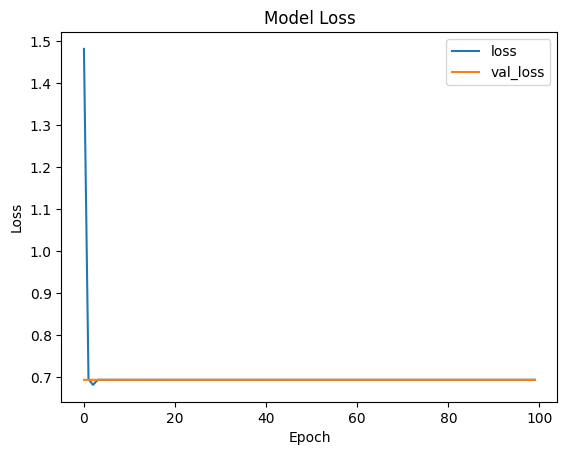

3/3 [==============================] - 0s 2ms/step


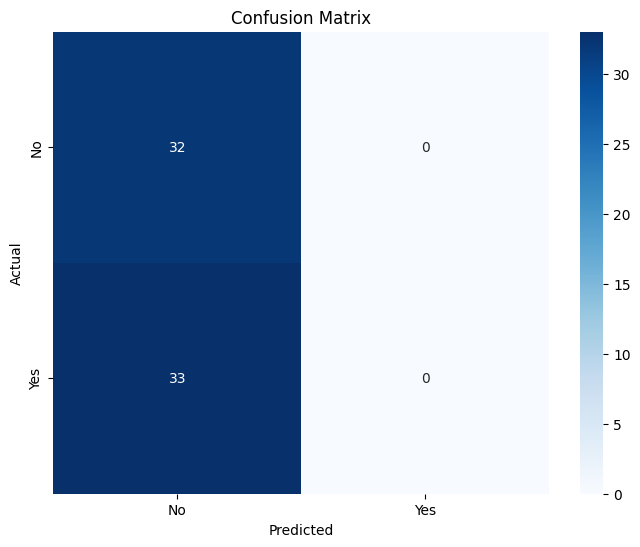

              precision    recall  f1-score   support

          No       0.49      1.00      0.66        32
         Yes       0.00      0.00      0.00        33

    accuracy                           0.49        65
   macro avg       0.25      0.50      0.33        65
weighted avg       0.24      0.49      0.32        65



/opt/anaconda3/envs/test/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/test/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/test/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [30]:
from sklearn.model_selection import train_test_split

import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import GridSearchCV


# Define the features and target variable
features = weather_feature_names + ['day_of_year']
target = 'PowderyMildew'

X = observations_df[features]
y = observations_df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(2048, activation='relu', input_shape=(len(features),)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation ='sigmoid')  # Output layer
])
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test MAE: {mae}")
# Plot training history
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()
# Save the model
model.save('powdery_mildew_model.h5')
# Load the model
loaded_model = tf.keras.models.load_model('powdery_mildew_model.h5')
# Make predictions
predictions = loaded_model.predict(X_test)
# Display predictions
predictions_df = pd.DataFrame({'Predicted': predictions.flatten(), 'Actual': y_test})
predictions_df.head()
# Save predictions to CSV
predictions_df.to_csv('predictions.csv', index=False)
# Save the observations DataFrame with features to CSV
observations_df.to_csv('observations_with_features.csv', index=False)
# Save the weather DataFrame to CSV
weather_df.to_csv('weather_data_with_features.csv', index=False)

# test and output confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
# Convert predictions to binary classification
threshold = 0.5
y_pred_binary = (predictions.flatten() > threshold).astype(int)
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
# Print classification report
print(classification_report(y_test, y_pred_binary, target_names=['No', 'Yes']))


Epoch 1/10
102/102 [==============================] - 1s 7ms/step - loss: 6.4501 - accuracy: 0.5490 - val_loss: 2.4365 - val_accuracy: 0.6538
Epoch 2/10
102/102 [==============================] - 0s 2ms/step - loss: 1.9907 - accuracy: 0.5882 - val_loss: 1.5864 - val_accuracy: 0.6346
Epoch 3/10
102/102 [==============================] - 0s 2ms/step - loss: 1.5324 - accuracy: 0.6127 - val_loss: 1.4250 - val_accuracy: 0.5962
Epoch 4/10
102/102 [==============================] - 0s 2ms/step - loss: 1.2175 - accuracy: 0.6324 - val_loss: 0.9687 - val_accuracy: 0.5962
Epoch 5/10
102/102 [==============================] - 0s 2ms/step - loss: 0.9734 - accuracy: 0.6225 - val_loss: 0.9153 - val_accuracy: 0.5769
Epoch 6/10
102/102 [==============================] - 0s 2ms/step - loss: 0.9452 - accuracy: 0.6716 - val_loss: 1.0120 - val_accuracy: 0.6923
Epoch 7/10
102/102 [==============================] - 0s 2ms/step - loss: 1.0041 - accuracy: 0.5686 - val_loss: 1.3445 - val_accuracy: 0.5385
Epoch 

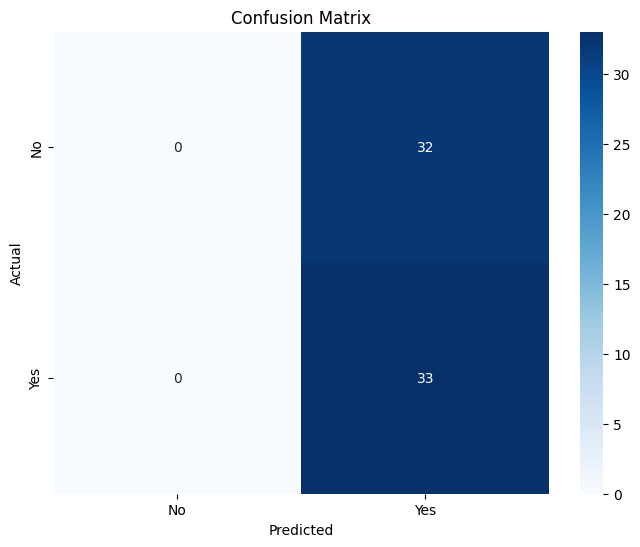

              precision    recall  f1-score   support

          No       0.00      0.00      0.00        32
         Yes       0.51      1.00      0.67        33

    accuracy                           0.51        65
   macro avg       0.25      0.50      0.34        65
weighted avg       0.26      0.51      0.34        65



/opt/anaconda3/envs/test/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/test/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/test/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [35]:
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.5, 1],
    'batch_size': [2, 4, 8, 16, 32, 64, 128],
    'num_layers': [1, 2, 3, 4, 5, 6, 7, 8],
    'neurons': [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192],
    'epochs': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, 250, 500, 1000]
}

# Define the model
def create_model(learning_rate, batch_size, num_layers, neurons, epochs):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(neurons, activation='relu', input_shape=(len(features),)))
    for _ in range(num_layers - 1):
        model.add(tf.keras.layers.Dense(neurons, activation='relu'))
        model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(1, activation ='sigmoid'))  # Output layer
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return (model, batch_size, epochs)


# Create a function to train and evaluate the model
def train_and_evaluate_model(learning_rate, batch_size, num_layers, neurons, epochs):
    model, batch_size, epochs = create_model(learning_rate, batch_size, num_layers, neurons, epochs)
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)
    loss, mae = model.evaluate(X_test, y_test)
    return mae
# Perform grid search
best_mae = float('inf')
best_params = None

for learning_rate in param_grid['learning_rate']:
    for batch_size in param_grid['batch_size']:
        for num_layers in param_grid['num_layers']:
            for neurons in param_grid['neurons']:
                for epochs in param_grid['epochs']:
                    mae = train_and_evaluate_model(learning_rate, batch_size, num_layers, neurons, epochs)
                    if mae < best_mae:
                        best_mae = mae
                        best_params = (learning_rate, batch_size, num_layers, neurons, epochs)
print(f"Best MAE: {best_mae}")
print(f"Best Parameters: Learning Rate: {best_params[0]}, Batch Size: {best_params[1]}, Num Layers: {best_params[2]}, Neurons: {best_params[3]}, Epochs: {best_params[4]}")
# Save the best model
best_model = create_model(*best_params)[0]
best_model.fit(X_train, y_train, epochs=best_params[4], batch_size=best_params[1], validation_split=0.2)
best_model.save('best_powdery_mildew_model.h5')
# Load the best model
loaded_best_model = tf.keras.models.load_model('best_powdery_mildew_model.h5')
# Make predictions with the best model
best_predictions = loaded_best_model.predict(X_test)
# Display predictions
best_predictions_df = pd.DataFrame({'Predicted': best_predictions.flatten(), 'Actual': y_test})
best_predictions_df.head()
# output confusion matrix
# Convert predictions to binary classification
threshold = 0.5
y_pred_binary = (best_predictions.flatten() > threshold).astype(int)
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
# Print classification report
print(classification_report(y_test, y_pred_binary, target_names=['No', 'Yes']))


